In [2]:
from pyteomics import mgf
import pandas as pd
import numpy as np
import glob as glob
import os
import matplotlib.pyplot as plt
import networkx as nx


In [3]:
# G = nx.read_graphml('../data/structural_clusters_network.graphml')
G = nx.read_graphml('../data/network.graphml')
df = dict(G.nodes(data=True))
df = pd.DataFrame(df).T
df.index.name = 'node_id'
df.reset_index(inplace=True,drop=False)
df.head()

,node_id,n,round3_precursor_mz,assumed_adduct,h_to_c,max_score_analog,best_match_method_analog,inchi_key_analog,formula_analog,max_matches_identity,...,o,dbe,n_to_c,max_score_identity,precursor_mz_analog,dbe_ai,p_to_c,mcs_structural_cluster_number,mcs_structural_pattern,mcs_similarity
0,0.0,0.0,187.097,[M-H]-,1.777778,0.21896,rem_predicted_score_original_rem,BDJRBEYXGGNYIS-UHFFFAOYSA-N,C9H16O4,3.0,...,4.0,2.0,0.0,0.999616,187.097559,-2.0,0.0,10,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]-&!@...,0.818182
1,40.0,0.0,173.082,[M-H]-,1.75,0.197489,rem_predicted_score_nl_rem,TYFQFVWCELRYAO-UHFFFAOYSA-N,C8H14O4,11.0,...,4.0,2.0,0.0,0.93509,173.081932,-2.0,0.0,10,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]-&!@...,0.818182
2,45.0,0.0,203.092,[M-H]-,1.777778,0.173887,rem_predicted_score_nl_rem,SDAXMMUAZRUWNL-UHFFFAOYSA-N,C9H14O4,NaN,...,5.0,2.0,0.0,NaN,185.0819,-3.0,0.0,-1,NaN,0.0
3,111.0,0.0,201.113,[M-H]-,1.8,0.219998,rem_predicted_score_original_rem,CXMXRPHRNRROMY-UHFFFAOYSA-N,C10H18O4,3.0,...,4.0,2.0,0.0,0.994669,201.113,-2.0,0.0,10,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]-&!@...,0.818182
4,552.0,0.0,231.088,[M-H]-,1.6,0.164211,rem_predicted_score_original_rem,BDJRBEYXGGNYIS-UHFFFAOYSA-N,C9H16O4,NaN,...,6.0,3.0,0.0,NaN,187.097559,-3.0,0.0,10,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]-&!@...,0.818182


In [10]:
dittmar = pd.read_csv('../data/Zark_Dittmar_DOM_molec-comp.tab',sep='\t',skiprows=19)
dittmar.columns = ['mz','formula','aabw','emw','nadw','northsea','lake']
# dittmar['max_abundance'] = dittmar[['aabw','emw','nadw','northsea','lake']].max(axis=1)
# dittmar['max_abundance'] = dittmar['max_abundance']/dittmar['max_abundance'].max()
# idx = dittmar['max_abundance']>=0.0001
# dittmar = dittmar[idx]
idx = dittmar['formula']!='no reference'
dittmar = dittmar[idx]
dittmar.drop_duplicates('formula',inplace=True)
dittmar.drop(columns=['mz'],inplace=True)
dittmar.set_index('formula',inplace=True,drop=True)
dittmar.columns = ['Quant: %s'%c for c in dittmar.columns]


# Add values from "dittmar" to nodes in "G"
for node_id, data in G.nodes(data=True):
    predicted_formula = data['predicted_formula']
    if predicted_formula in dittmar.index:
        dittmar_values = dittmar.loc[predicted_formula].to_dict()
        G.nodes[node_id].update(dittmar_values)

# nx.write_graphml(G,'../data/structural_clusters_network_with_fticr-data.graphml')   
nx.write_graphml(G,'../data/network_with_fticr-data.graphml')   


In [34]:


# n
original_index = nx.get_node_attributes(G, 'original_index')
mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
mcs_structural_pattern = nx.get_node_attributes(G, 'mcs_structural_pattern')
smiles_identity = nx.get_node_attributes(G, 'smiles_identity')
temp = {}
for c in dittmar.columns:
    temp[c] = nx.get_node_attributes(G, c)
temp = pd.DataFrame(temp)

n = temp.copy()
m = n.min(axis=1)
m = n.values - m.values[:,None]
n = pd.DataFrame(m,index=n.index,columns=n.columns)

# m = n.max(axis=1)
# m = n.values / m.values[:,None]
# n = pd.DataFrame(m,index=n.index,columns=n.columns)

temp = pd.merge(n,pd.DataFrame({'cluster_id':mcs_structural_cluster_number}),left_index=True,right_index=True)
temp = pd.merge(temp,pd.DataFrame({'cluster_pattern':mcs_structural_pattern}),left_index=True,right_index=True)
temp = pd.merge(temp,pd.DataFrame({'smiles_identity':smiles_identity}),left_index=True,right_index=True)
temp = pd.merge(temp,pd.DataFrame({'original_index':original_index}),left_index=True,right_index=True)
cols = [c for c in temp.columns if 'Quant' in c]
cluster_df = temp.groupby(['cluster_id','cluster_pattern'])[cols].mean()
identity_df = temp.groupby(['cluster_id','cluster_pattern','smiles_identity'])[cols].mean()


In [ ]:
# BEGIN IONS
# DATABASE=metatlas
# PRECURSOR_MZ=197.046
# POLARITY=negative
# ADDUCT=[M-H]-
# FRAGMENTATION_METHOD=cid
# COLLISION_ENERGY=nan
# INSTRUMENT=nan
# INSTRUMENT_TYPE=nan
# FORMULA=C9H10O5
# INCHI_KEY=JMSVCTWVEWCHDZ-UHFFFAOYSA-N
# INCHI=InChI=1S/C9H10O5/c1-13-6-3-5(9(11)12)4-7(14-2)8(6)10/h3-4,10H,1-2H3,(H,11,12)
# SMILES=COc1cc(C(=O)O)cc(OC)c1O
# INTERNAL_UUID=c81b48faf4e44a9ba774859cfcf11e08
# COMPOUND_NAME=SYRINGIC ACID
# PARENT_MASS=198.0528234
# 65.0026 7664.0 
# 67.0187 12659.0 
# 68.9981 10008.0 
# 83.0138 33078.0 
# 83.8999 6074.0 
# 89.0034 43073.0 
# 91.0188 14410.0 
# 92.4081 8778.0 
# 95.014 101206.0 
# 97.0296 28190.0 
# 104.315 7224.0 
# 106.006 41141.0 
# 110.001 10959.0 
# 110.197 5819.0 
# 111.009 37698.0 
# 112.988 11268.0 
# 116.929 10992.0 
# 120.51 6195.0 
# 120.993 25511.0 
# 121.03 1882770.0 
# 123.009 1515310.0 
# 123.045 8049.0 
# 127.004 44101.0 
# 132.198 6889.0 
# 136.017 7797.0 
# 136.988 33489.0 
# 137.025 31600.0 
# 138.032 2063050.0 
# 139.004 49893.0 
# 139.04 14537.0 
# 153.056 3163220.0 
# 153.128 28853.0 
# 154.027 26919.0 
# 154.999 44782.0 
# 166.999 3343680.0 
# 169.013 7325.0 
# 178.892 9968.0 
# 181.014 104491.0 
# 181.382 9709.0 
# 182.022 14620300.0 
# 182.665 9204.0 
# 197.046 5763690.0 
# END IONS

In [37]:
temp.sort_values('Quant: aabw',ascending=False,inplace=True)
temp[pd.notna(temp['smiles_identity'])]

,Quant: aabw,Quant: emw,Quant: nadw,Quant: northsea,Quant: lake,cluster_id,cluster_pattern,smiles_identity,original_index
1265.0,25.564809,27.329391,22.340339,10.159460,0.000000,21,[#6&!R]=&!@[#6&R]1-&@[#6&R]-&@[#6&R]23-&@[#6&R...,C[C@@H]1C(=O)O[C@H]2C[C@@]34C5C[C@@H](C(C)(C)C...,258
914.0,13.006762,12.489777,10.683747,5.735582,0.000000,21,[#6&!R]=&!@[#6&R]1-&@[#6&R]-&@[#6&R]23-&@[#6&R...,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C[C@H](O)[...,177
689.0,7.209096,7.512321,5.952475,4.408259,0.000000,14,[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]=&!@[#...,O=C(O)CC/C=C\C[C@@H](O)/C=C/C=C/C=C\[C@@H](O)C...,44365
1263.0,7.209096,7.512321,5.952475,4.408259,0.000000,14,[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]=&!@[#...,O=C(O)CC/C=C\C[C@@H](O)/C=C/C=C/C=C\[C@@H](O)C...,257
1076.0,5.195589,1.274355,4.075317,0.355088,0.000000,14,[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]=&!@[#...,CCCCC[C@H](O)CC(=O)CCc1ccc(O)c(OC)c1,34685
...,...,...,...,...,...,...,...,...,...
439.0,0.000000,0.369785,0.089123,1.289165,1.676579,25,"[#6&!R]-&!@[#6&R]1:,-;@[#6&R]:,-;@[#6&R]:,-;@[...",O=C(O)CCc1ccccc1O,12369
191.0,0.000000,0.369785,0.089123,1.289165,1.676579,25,"[#6&!R]-&!@[#6&R]1:,-;@[#6&R]:,-;@[#6&R]:,-;@[...",O=C(O)[C@H](O)Cc1ccccc1,33
90.0,0.000000,0.201960,0.030130,2.199657,7.490977,28,[#6&R]1:&@[#6&R]:&@[#6&R](-&!@[#8&!R]):&@[#6&R...,Cc1c(O)c(O)cc2oc3cc(O)cc(O)c3c(=O)c12,40118
342.0,0.000000,0.000000,0.326367,1.403864,3.864331,27,"[#6&R](-,:;@[#6&R]-,:;@[#6&R]-&!@[#6&R]1:&@[#6...",COc1ccc(-c2coc3cc(O)ccc3c2=O)cc1OC,45060


In [43]:
s = temp.loc['914.0']['smiles_identity']

In [44]:
from rdkit.Chem import Descriptors
# s = 'O=C(O)CCCCCCCCC(=O)O'
m = Chem.MolFromSmiles(s)
exact_mass = Descriptors.ExactMolWt(m)
print(exact_mass-1.007276466812)


363.1449266411879


In [18]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculate the pairwise distances between rows
distances = cluster_df.values

# Perform hierarchical clustering
Z = linkage(distances, method='average', metric='euclidean')

# Get the order of the rows based on the clustering
order = dendrogram(Z, no_plot=True)['leaves']

# Reorder the rows of cluster_df
cluster_df = cluster_df.iloc[order]

# Show the reordered cluster_df
cluster_df


,,Quant: aabw,Quant: emw,Quant: nadw,Quant: northsea,Quant: lake
cluster_id,cluster_pattern,,,,,
19,[#8&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@1)-&!@[#8&!R],1.000000,0.550300,0.702322,0.227639,0.000000
20,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R](:&@[#6&R]:&@1-&!@[#8&!R])-&!@[#8&!R])-&@[#6&R]1(-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R](-&@[#6&R]-&@1)(-&!@[#6&!R])-&!@[#6&!R])-&@[#6&R](-&@[#8&R]-&@[#6&R]-&@[#6&R]-&!@[#8&!R])=&!@[#8&!R],1.000000,0.741690,0.230527,0.807533,0.069574
23,[#6&!R]=&!@[#6&!R](-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R])-&!@[#6&R](-&@[#6&R]-&@[#6&R]-&@[#6&R]-&!@[#6&!R])-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R],0.716422,0.845410,0.363449,0.733854,0.000000
18,[#6&!R]=&!@[#6&R]1-&@[#6&R](=&!@[#8&!R])-&@[#8&R]-&@[#6&R](-&@[#6&R]-&@1-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R])-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R],0.454685,0.785093,0.464532,0.830207,0.013776
24,[#6&!R]-&!@[#6&R]1-&@[#6&R](=&!@[#8&!R])-&@[#8&R]-&@[#6&R]-&@[#6&R]2-&@[#6&R]-&@13-&@[#6&R]-&@[#6&R](-&@[#6&R]-&@[#6&R]-&@3-&@[#6&R]=&@[#6&R]-&@2-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R])(-&!@[#6&!R])-&!@[#6&!R],0.472571,0.799608,0.451503,0.698916,0.105851
13,[#6&!R]-&!@[#8&!R]-&!@[#6&R]1:&@[#6&R](-&!@[#6&!R]):&@[#6&R]2:&@[#6&R](:&@[#6&R](:&@[#6&R]:&@1-&!@[#6&!R]-&!@[#6&!R]=&!@[#6&!R](-&!@[#6&!R])-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](-&!@[#6&!R])-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R])-&!@[#8&!R])-&@[#6&R](-&@[#8&R]-&@[#6&R]-&@2)=&!@[#8&!R],0.731487,0.954638,0.364404,0.467148,0.159948
17,[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]=&!@[#6&!R]-&!@[#6&R]1-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@1-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R],0.934086,0.913580,0.548705,0.652627,0.000000
14,[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]=&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]=&!@[#6&!R]-&!@[#6&!R]=&!@[#6&!R]-&!@[#6&!R]=&!@[#6&!R]-&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R],0.866155,0.914828,0.752353,0.530790,0.008137
21,[#6&!R]=&!@[#6&R]1-&@[#6&R]-&@[#6&R]23-&@[#6&R]-&@[#6&R]-&@1-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@2-&@[#6&R]-&@[#6&R](-&@[#6&R]-&@3-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R])-&@[#6&R](-&@[#6&R]-&@[#6&R]-&@[#6&R])-&!@[#6&!R],0.853571,0.934683,0.594550,0.422718,0.121098


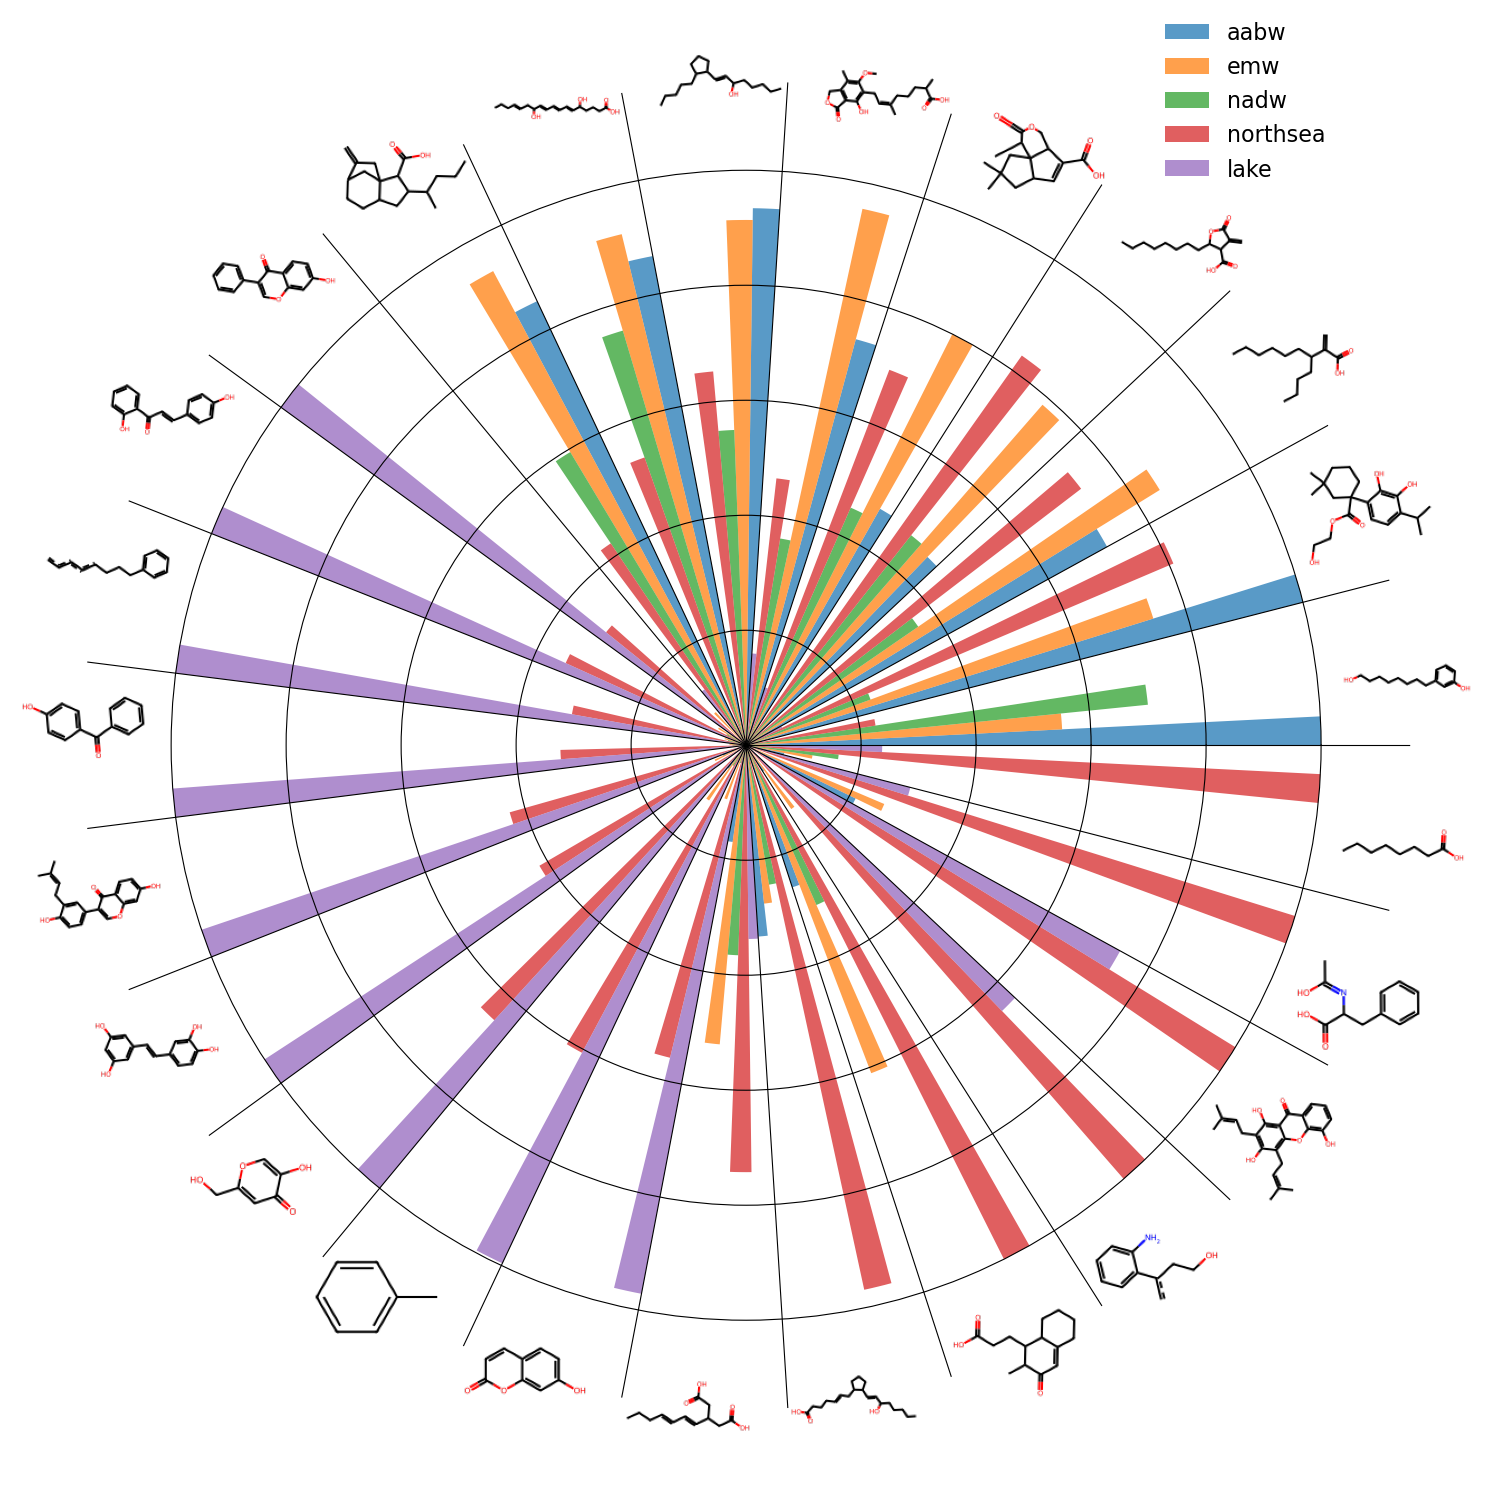

In [21]:
# Create the polar plot
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15), subplot_kw={'projection': 'polar'})

# Define the angles for each side of the polygons
angles = np.linspace(0, 2 * np.pi, cluster_df.shape[0] + 1)[:-1]
shift_amount = np.diff(angles)[0] / cluster_df.shape[1]
for iii in range(cluster_df.shape[1]):
    # Define the lengths of the bars
    bar_lengths = cluster_df.values[:, iii]
    # Plot the bars
    ax.bar(angles + iii * shift_amount, bar_lengths*1, width=shift_amount, align='edge', alpha=0.74, label=cluster_df.columns[iii].replace('Quant: ',''))

# Set the labels for each side of the polygons
ax.set_xticks(angles)
ax.set_xticklabels(['' for i in range(cluster_df.shape[0])])

# Set the title of the plot
tick_labels = ax.xaxis.get_ticklabels()

m = ax.get_ylim()[1]*1.1
ax.set_ylim(0, m)

from PIL import Image
from io import BytesIO
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol)#,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

counter = 0
for i, row in cluster_df.iterrows():
    mol = Chem.MolFromSmarts(i[1])
    s = Chem.MolToSmiles(mol)
    mol = Chem.MolFromSmiles(s)
    d2d = Draw.MolDraw2DCairo(120, 120)
    dopts = d2d.drawOptions()
    dopts.setBackgroundColour((0, 0, 0, 0))
    im = show_mol(d2d, mol)

    imagebox = OffsetImage(im, zoom=0.8)
    ax.add_artist(AnnotationBbox(imagebox, (angles[counter] + shift_amount*2, m * 1), frameon=False))

    # ax.bar(angles[counter], [0.02],bottom=1, width=0.054*3, align='edge', alpha=0.74,color='grey')#, label=cluster_df.columns[iii])

    counter += 1

ax.spines['polar'].set_visible(False)
ax.grid(color='black')
# Hide the y tick labels
ax.set_yticklabels([])

# Position the legend outside of the plot area
ax.legend(bbox_to_anchor=(0.8, 1.06), loc='upper left',fontsize=16,frameon=False)

plt.tight_layout()
fig.savefig('fticr-structural_cluster_plot.pdf')#, dpi=300)

In [25]:
# df['in_zarkdittmar'] = df['predicted_formula'].isin(in_both)
# cols = ['original_index','in_zarkdittmar']
# df[cols].to_csv('in_zarkdittmar.csv',index=False)